In [1]:
# %% [markdown]
# # Sentiment Analysis with RoBERTa Transformer
# Using Twitter-trained RoBERTa model for EA Forum Posts

# %%
# Install required packages (run once)
# !pip install pandas transformers torch accelerate matplotlib seaborn wordcloud tqdm

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1
print(f"Using: {'GPU 🚀' if device == 0 else 'CPU'}")

# %%
# Load the data
df = pd.read_csv('ea_forum_posts.csv')
print(f"Loaded {len(df)} posts")

# Combine title and body for better context
df['full_text'] = df['title'].fillna('') + '. ' + df['body_preview'].fillna('')
df['full_text'] = df['full_text'].str.strip()

df.head()

# %% [markdown]
# ## RoBERTa Model
# Using Cardiff NLP's RoBERTa trained on Twitter data - excellent for informal text and forums

# %%
# Initialize RoBERTa sentiment analysis pipeline
print("Loading RoBERTa model (this may take a minute)...")

sentiment_roberta = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device,
    truncation=True,
    max_length=512
)

print("✅ RoBERTa model loaded!")

# %%
# Function to safely analyze sentiment with error handling
def analyze_sentiment(text, analyzer):
    """Analyze sentiment with error handling for long/problematic texts"""
    if pd.isna(text) or not text.strip():
        return {'label': 'neutral', 'score': 0.0}
    
    try:
        # Truncate very long texts
        text = str(text)[:1500]
        result = analyzer(text)[0]
        return result
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return {'label': 'neutral', 'score': 0.0}

# %%
# Analyze with RoBERTa
print("Analyzing sentiment with RoBERTa...")
tqdm.pandas(desc="RoBERTa Analysis")

roberta_results = df['full_text'].progress_apply(
    lambda x: analyze_sentiment(x, sentiment_roberta)
)

df['roberta_label'] = roberta_results.apply(lambda x: x['label'])
df['roberta_score'] = roberta_results.apply(lambda x: x['score'])

# Map labels to standardized format
label_map_roberta = {
    'positive': 'Positive',
    'negative': 'Negative', 
    'neutral': 'Neutral'
}
df['sentiment'] = df['roberta_label'].map(label_map_roberta)
df['confidence'] = df['roberta_score']

# Create compound score (-1 to 1)
def calculate_compound(row):
    label = row['sentiment']
    score = row['confidence']
    if label == 'Positive':
        return score
    elif label == 'Negative':
        return -score
    return 0

df['compound_score'] = df.apply(calculate_compound, axis=1)

# %%
# Display Results Summary
print("=" * 60)
print("ROBERTA SENTIMENT ANALYSIS RESULTS")
print("=" * 60)

print(f"\n📊 Total Posts Analyzed: {len(df)}")

print("\n" + "-" * 40)
print("Sentiment Distribution:")
print("-" * 40)
print(df['sentiment'].value_counts())

print(f"\nPercentages:")
print(df['sentiment'].value_counts(normalize=True).mul(100).round(1))

print(f"\nAverage Compound Score: {df['compound_score'].mean():.3f}")
print(f"Average Confidence: {df['confidence'].mean():.3f}")




/Users/porkr/projects/ea_scraper/fc2026/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using: CPU
Loaded 1551 posts
Loading RoBERTa model (this may take a minute)...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ RoBERTa model loaded!
Analyzing sentiment with RoBERTa...


RoBERTa Analysis:   0%|          | 0/1551 [00:00<?, ?it/s]

ROBERTA SENTIMENT ANALYSIS RESULTS

📊 Total Posts Analyzed: 1551

----------------------------------------
Sentiment Distribution:
----------------------------------------
sentiment
Negative    1221
Neutral      280
Positive      50
Name: count, dtype: int64

Percentages:
sentiment
Negative    78.7
Neutral     18.1
Positive     3.2
Name: proportion, dtype: float64

Average Compound Score: -0.595
Average Confidence: 0.765


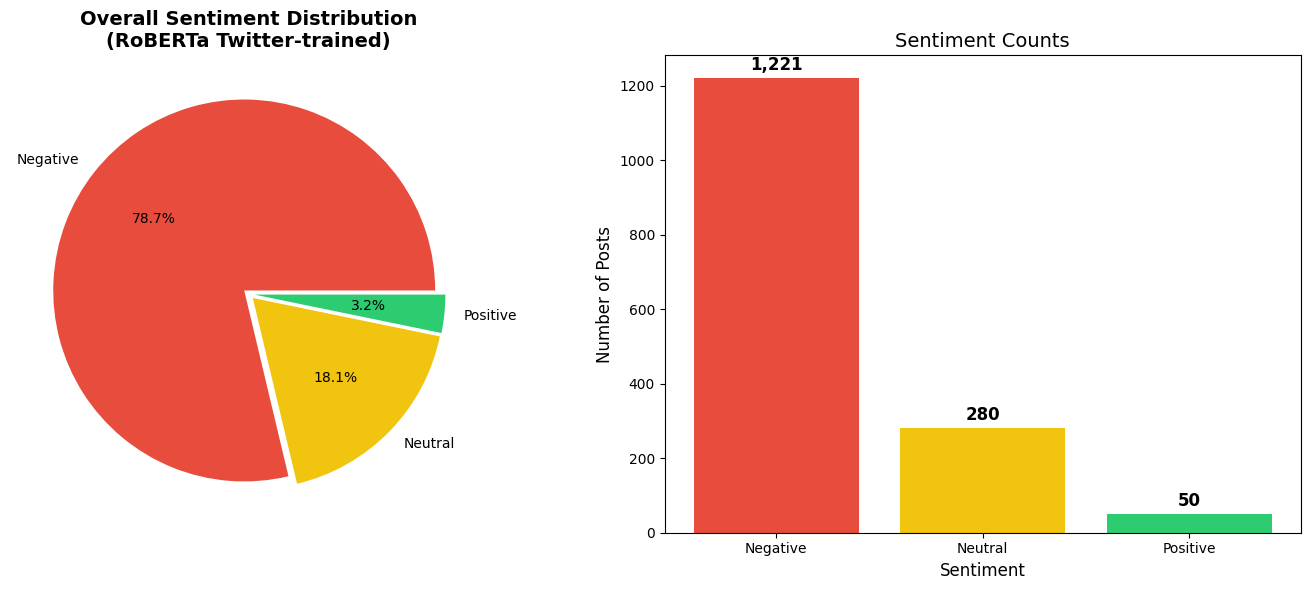

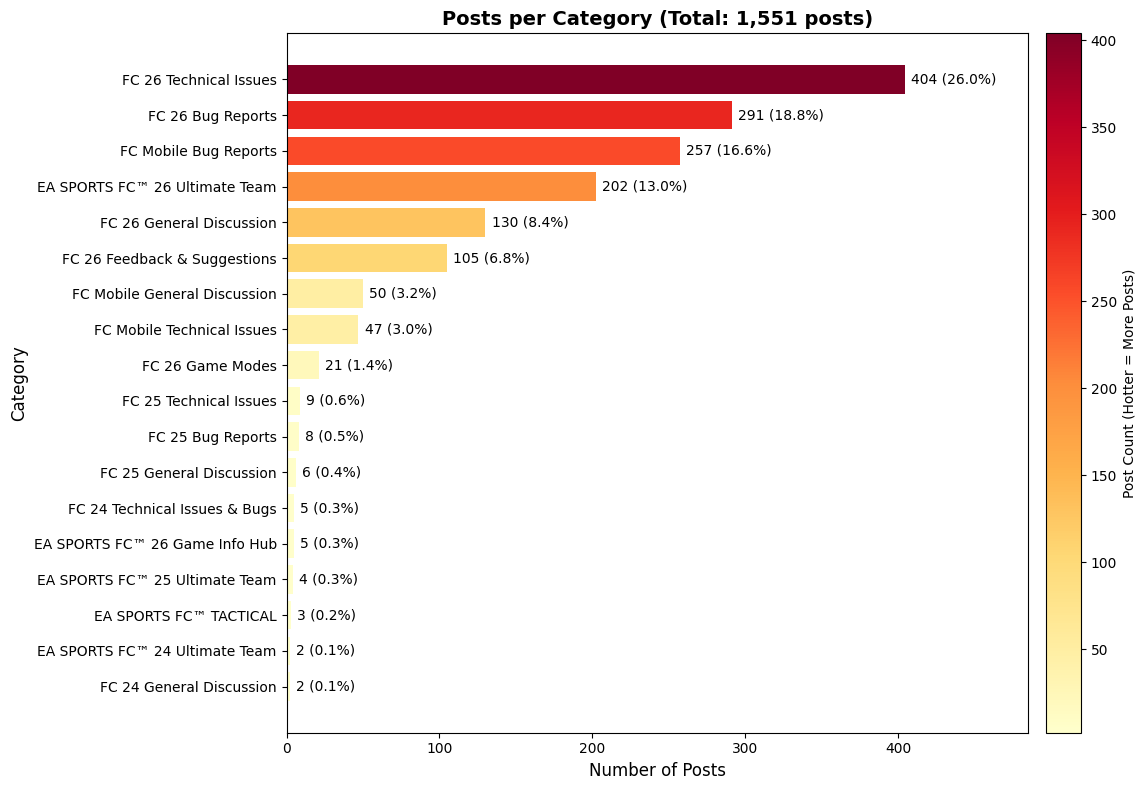


----------------------------------------
📊 POSTS PER CATEGORY:
----------------------------------------
  FC 26 Technical Issues: 404 posts (26.0%)
  FC 26 Bug Reports: 291 posts (18.8%)
  FC Mobile Bug Reports: 257 posts (16.6%)
  EA SPORTS FC™ 26 Ultimate Team: 202 posts (13.0%)
  FC 26 General Discussion: 130 posts (8.4%)
  FC 26 Feedback & Suggestions: 105 posts (6.8%)
  FC Mobile General Discussion: 50 posts (3.2%)
  FC Mobile Technical Issues: 47 posts (3.0%)
  FC 26 Game Modes: 21 posts (1.4%)
  FC 25 Technical Issues: 9 posts (0.6%)
  FC 25 Bug Reports: 8 posts (0.5%)
  FC 25 General Discussion: 6 posts (0.4%)
  FC 24 Technical Issues & Bugs: 5 posts (0.3%)
  EA SPORTS FC™ 26 Game Info Hub: 5 posts (0.3%)
  EA SPORTS FC™ 25 Ultimate Team: 4 posts (0.3%)
  EA SPORTS FC™ TACTICAL: 3 posts (0.2%)
  EA SPORTS FC™ 24 Ultimate Team: 2 posts (0.1%)
  FC 24 General Discussion: 2 posts (0.1%)


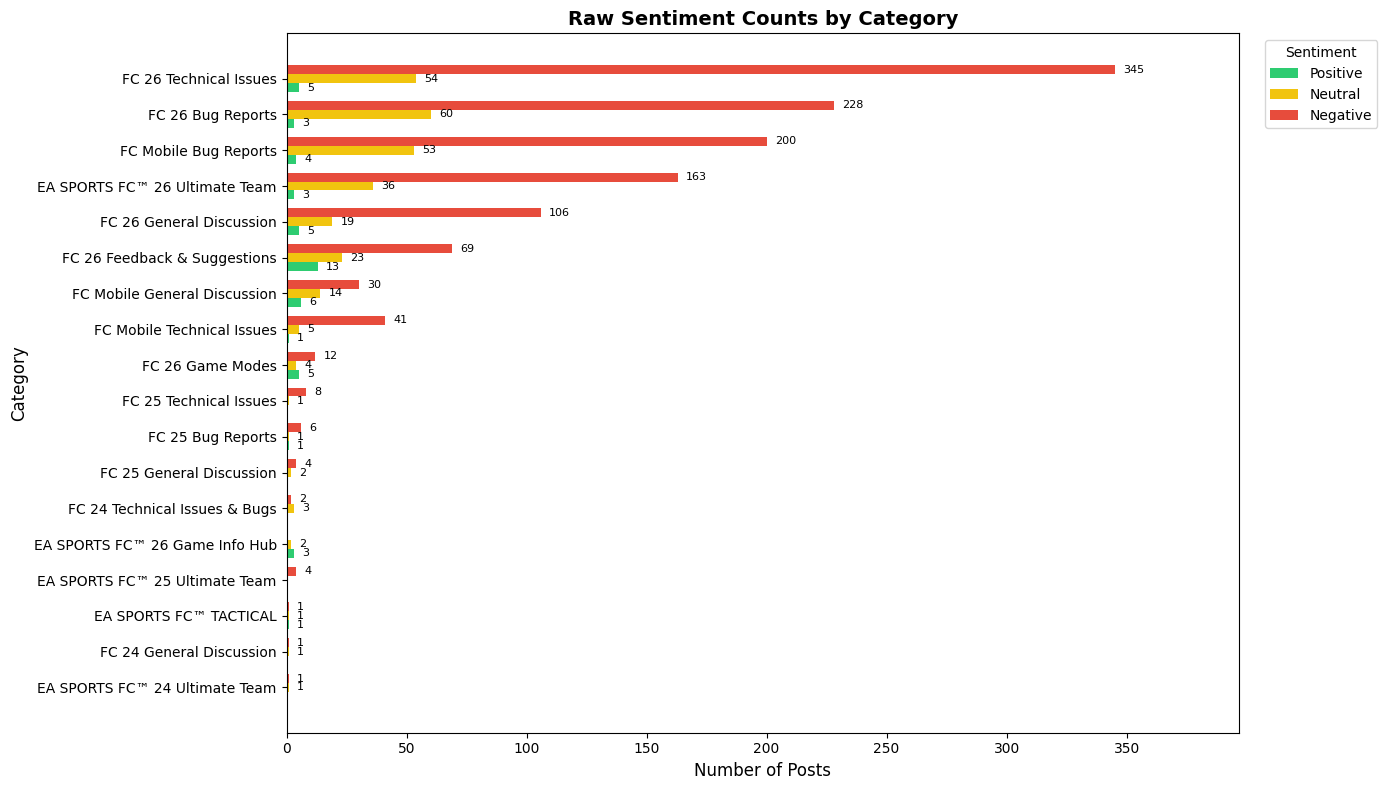


------------------------------------------------------------
📊 RAW SENTIMENT COUNTS BY CATEGORY:
------------------------------------------------------------
sentiment                       Positive  Neutral  Negative  Total
category                                                          
FC 26 Technical Issues                 5       54       345    404
FC 26 Bug Reports                      3       60       228    291
FC Mobile Bug Reports                  4       53       200    257
EA SPORTS FC™ 26 Ultimate Team         3       36       163    202
FC 26 General Discussion               5       19       106    130
FC 26 Feedback & Suggestions          13       23        69    105
FC Mobile General Discussion           6       14        30     50
FC Mobile Technical Issues             1        5        41     47
FC 26 Game Modes                       5        4        12     21
FC 25 Technical Issues                 0        1         8      9
FC 25 Bug Reports                    

<Figure size 1400x800 with 0 Axes>

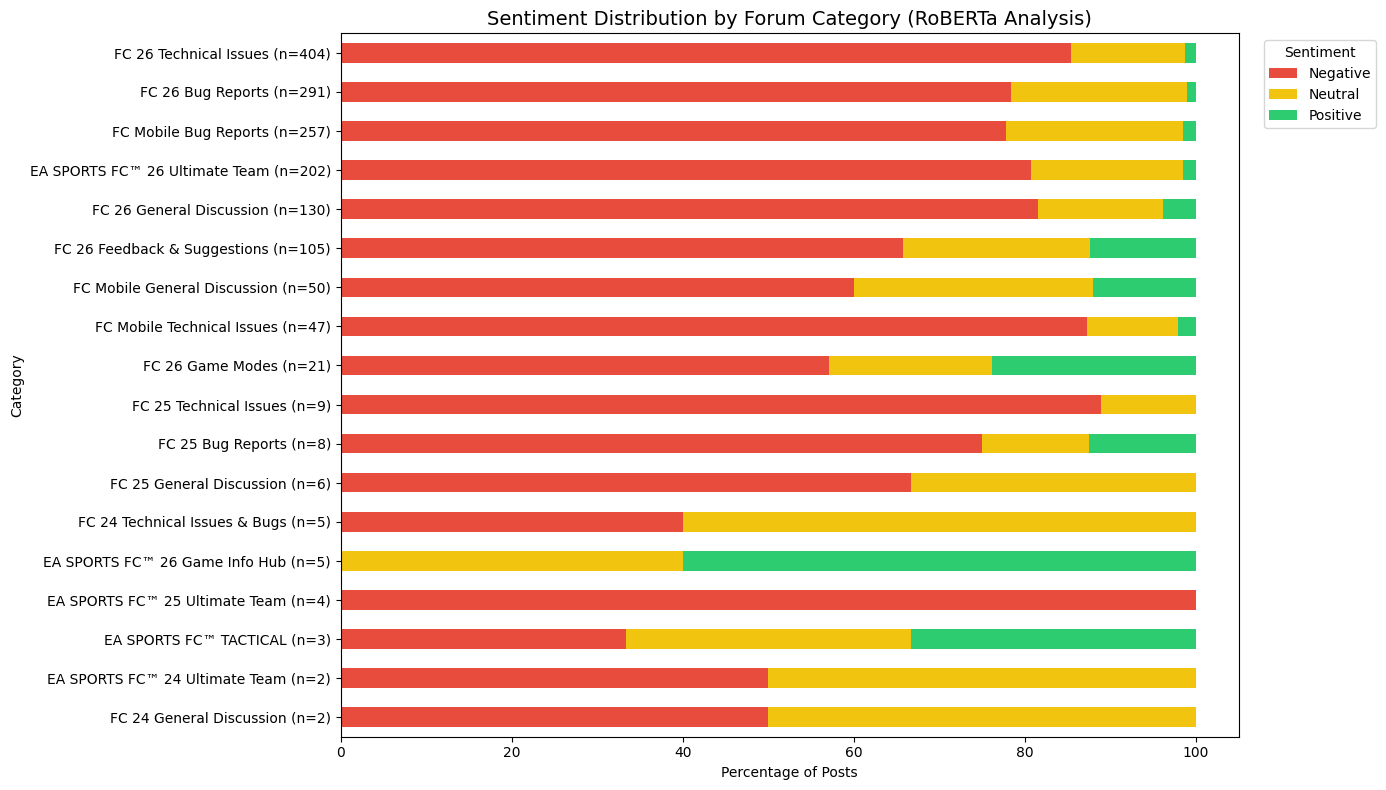

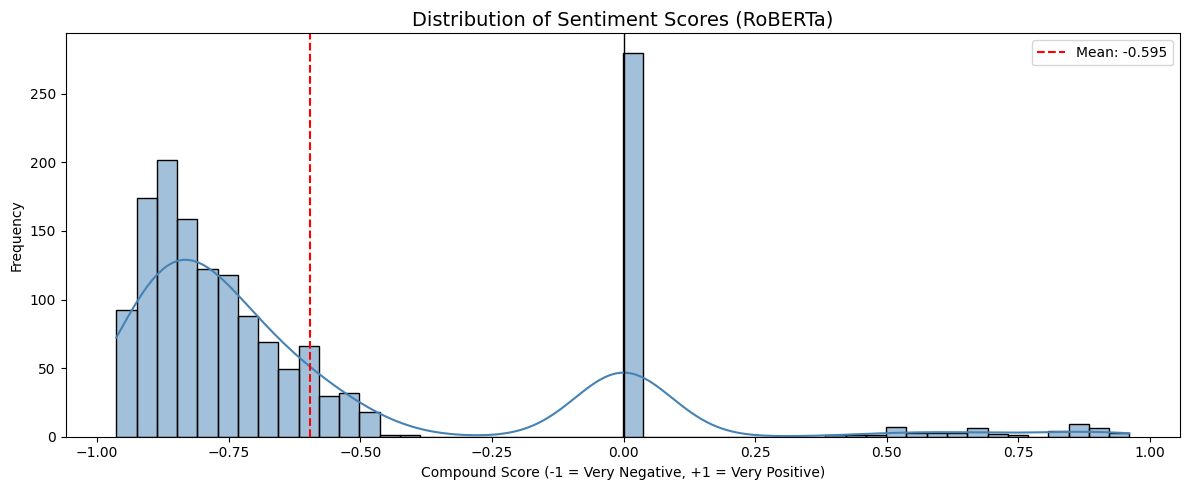

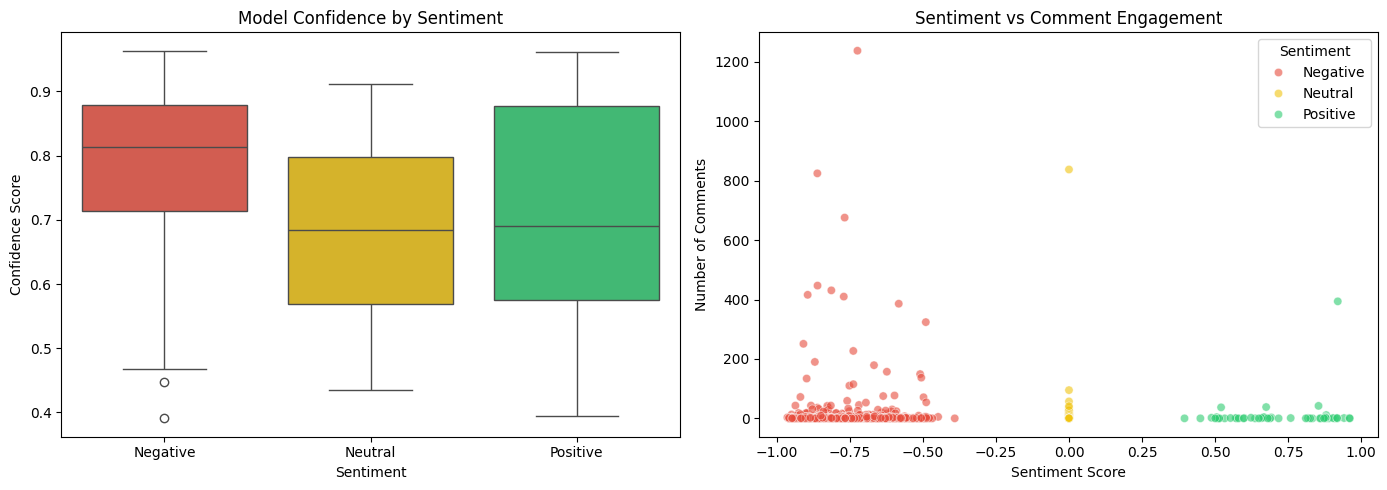

✅ Results exported to 'ea_forum_sentiment_roberta.csv'

📊 FINAL SENTIMENT ANALYSIS REPORT

📈 OVERVIEW
────────────────────────────────────────
Total Posts Analyzed: 1,551
Model: RoBERTa (Twitter-trained)
Average Sentiment Score: -0.595
Average Model Confidence: 0.765

📊 SENTIMENT BREAKDOWN
────────────────────────────────────────
🟢 Positive: 50 (3.2%)
🟡 Neutral:  280 (18.1%)
🔴 Negative: 1,221 (78.7%)

🎯 KEY INSIGHTS
────────────────────────────────────────
• Overall forum sentiment: NEGATIVE 😠
• Most discussed issues appear in negative posts
• High-engagement posts tend to be more negative

📁 FILES GENERATED
────────────────────────────────────────
• ea_forum_sentiment_roberta.csv (full results)
• sentiment_distribution.png
• posts_per_category.png (heatmap style)
• sentiment_counts_by_category.png (raw counts)
• sentiment_by_category.png (percentages)
• compound_score_distribution.png
• confidence_and_engagement.png
• correlation_matrix.png



In [4]:
# %%
# Visualization 1: Overall Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Positive': '#2ecc71', 'Neutral': '#f1c40f', 'Negative': '#e74c3c'}

# Pie chart
ax1 = axes[0]
sentiment_counts = df['sentiment'].value_counts()
ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=[colors.get(l, '#95a5a6') for l in sentiment_counts.index],
        explode=[0.03] * len(sentiment_counts))
ax1.set_title('Overall Sentiment Distribution\n(RoBERTa Twitter-trained)', fontsize=14, fontweight='bold')

# Bar chart with counts
ax2 = axes[1]
bars = ax2.bar(sentiment_counts.index, sentiment_counts.values,
               color=[colors.get(l, '#95a5a6') for l in sentiment_counts.index])
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.set_ylabel('Number of Posts', fontsize=12)
ax2.set_title('Sentiment Counts', fontsize=14)

# Add count labels on bars
for bar, count in zip(bars, sentiment_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sentiment_counts.values)*0.01,
             f'{count:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 2a: Category Post Counts (Heatmap Style)
if 'category' in df.columns:
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    
    plt.figure(figsize=(12, 8))
    
    # Get category counts and sort descending (already default for value_counts)
    category_counts = df['category'].value_counts()
    
    # Reverse order so highest count appears at the top of horizontal bar chart
    category_counts = category_counts.iloc[::-1]
    
    # Create heatmap colors based on counts (YlOrRd = Yellow-Orange-Red, hot colors for high values)
    norm = Normalize(vmin=category_counts.min(), vmax=category_counts.max())
    cmap = plt.cm.YlOrRd
    bar_colors = [cmap(norm(val)) for val in category_counts.values]
    
    # Create horizontal bar chart with heatmap colors
    bars = plt.barh(range(len(category_counts)), category_counts.values, color=bar_colors)
    plt.yticks(range(len(category_counts)), category_counts.index)
    
    # Add count and percentage labels on the bars
    total_posts = len(df)
    for i, (count, bar) in enumerate(zip(category_counts.values, bars)):
        pct = count / total_posts * 100
        plt.text(count + max(category_counts.values) * 0.01, i, f'{count:,} ({pct:.1f}%)', 
                 va='center', fontsize=10)
    
    # Add colorbar to show the scale
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
    cbar.set_label('Post Count (Hotter = More Posts)', fontsize=10)
    
    plt.xlabel('Number of Posts', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.title(f'Posts per Category (Total: {len(df):,} posts)', fontsize=14, fontweight='bold')
    plt.xlim(0, max(category_counts.values) * 1.20)  # Extra space for percentage labels
    plt.tight_layout()
    plt.savefig('posts_per_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary (use original descending order for readability)
    category_counts_print = df['category'].value_counts()
    print("\n" + "-" * 40)
    print("📊 POSTS PER CATEGORY:")
    print("-" * 40)
    for cat, count in category_counts_print.items():
        pct = count / len(df) * 100
        print(f"  {cat}: {count:,} posts ({pct:.1f}%)")

# %%
# Visualization 2b: Raw Sentiment Counts by Category
if 'category' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Get raw counts of each sentiment per category
    sentiment_by_cat = pd.crosstab(df['category'], df['sentiment'])
    
    # Reorder columns to Positive, Neutral, Negative
    col_order = [c for c in ['Positive', 'Neutral', 'Negative'] if c in sentiment_by_cat.columns]
    sentiment_by_cat = sentiment_by_cat[col_order]
    
    # Sort by total posts (descending) then reverse for horizontal bar
    sentiment_by_cat['_total'] = sentiment_by_cat.sum(axis=1)
    sentiment_by_cat = sentiment_by_cat.sort_values('_total', ascending=True)
    sentiment_by_cat = sentiment_by_cat.drop('_total', axis=1)
    
    # Create grouped horizontal bar chart
    y_pos = range(len(sentiment_by_cat))
    bar_height = 0.25
    
    for i, sentiment in enumerate(col_order):
        offset = (i - len(col_order)/2 + 0.5) * bar_height
        bars = ax.barh([y + offset for y in y_pos], sentiment_by_cat[sentiment], 
                       height=bar_height, label=sentiment, 
                       color=colors.get(sentiment, '#95a5a6'))
        
        # Add count labels
        for j, (val, bar) in enumerate(zip(sentiment_by_cat[sentiment], bars)):
            if val > 0:
                ax.text(val + max(sentiment_by_cat.max()) * 0.01, 
                       y_pos[j] + offset, f'{val:,}', 
                       va='center', fontsize=8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sentiment_by_cat.index)
    ax.set_xlabel('Number of Posts', fontsize=12)
    ax.set_ylabel('Category', fontsize=12)
    ax.set_title('Raw Sentiment Counts by Category', fontsize=14, fontweight='bold')
    ax.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xlim(0, sentiment_by_cat.max().max() * 1.15)
    
    plt.tight_layout()
    plt.savefig('sentiment_counts_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary table
    print("\n" + "-" * 60)
    print("📊 RAW SENTIMENT COUNTS BY CATEGORY:")
    print("-" * 60)
    summary = pd.crosstab(df['category'], df['sentiment'])
    summary = summary.reindex(columns=[c for c in ['Positive', 'Neutral', 'Negative'] if c in summary.columns])
    summary['Total'] = summary.sum(axis=1)
    summary = summary.sort_values('Total', ascending=False)
    print(summary.to_string())

# %%
# Visualization 2c: Sentiment by Category (Percentage Stacked)
if 'category' in df.columns:
    plt.figure(figsize=(14, 8))
    
    # Get category counts for labels (descending order by count)
    category_counts = df['category'].value_counts()
    
    # Calculate sentiment percentages by category
    category_sentiment = pd.crosstab(
        df['category'], 
        df['sentiment'], 
        normalize='index'
    ) * 100
    
    # Sort by category count (descending) - reindex to match category_counts order
    # Then reverse so highest count appears at top of horizontal bar chart
    category_sentiment = category_sentiment.reindex(category_counts.index)
    category_sentiment = category_sentiment.iloc[::-1]
    
    # Create labels with counts
    new_labels = [f"{cat} (n={category_counts[cat]:,})" for cat in category_sentiment.index]
    category_sentiment.index = new_labels
    
    # Plot
    category_sentiment.plot(
        kind='barh',
        stacked=True,
        color=[colors.get(c, '#95a5a6') for c in category_sentiment.columns],
        figsize=(14, 8)
    )
    
    plt.title('Sentiment Distribution by Forum Category (RoBERTa Analysis)', fontsize=14)
    plt.xlabel('Percentage of Posts')
    plt.ylabel('Category')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.savefig('sentiment_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()

# %%
# Visualization 3: Compound Score Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['compound_score'], bins=50, kde=True, color='steelblue')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.axvline(x=df['compound_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["compound_score"].mean():.3f}')
plt.title('Distribution of Sentiment Scores (RoBERTa)', fontsize=14)
plt.xlabel('Compound Score (-1 = Very Negative, +1 = Very Positive)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('compound_score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Visualization 4: Confidence Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence by sentiment
ax1 = axes[0]
sns.boxplot(data=df, x='sentiment', y='confidence', 
            palette=colors, ax=ax1, order=['Negative', 'Neutral', 'Positive'])
ax1.set_title('Model Confidence by Sentiment', fontsize=12)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Confidence Score')

# Sentiment vs Engagement
ax2 = axes[1]
if 'comments' in df.columns:
    sns.scatterplot(data=df, x='compound_score', y='comments', 
                    hue='sentiment', palette=colors, alpha=0.6, ax=ax2)
    ax2.set_title('Sentiment vs Comment Engagement', fontsize=12)
    ax2.set_xlabel('Sentiment Score')
    ax2.set_ylabel('Number of Comments')
    ax2.legend(title='Sentiment')

plt.tight_layout()
plt.savefig('confidence_and_engagement.png', dpi=150, bbox_inches='tight')
plt.show()


# %%
# Export results
output_columns = [
    'title', 'author', 'category', 'timestamp',
    'sentiment', 'confidence', 'compound_score',
    'views', 'likes', 'comments',
    'body_preview'
]

# Only include columns that exist
output_columns = [col for col in output_columns if col in df.columns]
output_df = df[output_columns].copy()

output_df.to_csv('ea_forum_sentiment_roberta.csv', index=False)
print("✅ Results exported to 'ea_forum_sentiment_roberta.csv'")

# %%
# Final Summary Report
print("\n" + "=" * 60)
print("📊 FINAL SENTIMENT ANALYSIS REPORT")
print("=" * 60)

total = len(df)
neg_count = (df['sentiment'] == 'Negative').sum()
pos_count = (df['sentiment'] == 'Positive').sum()
neu_count = (df['sentiment'] == 'Neutral').sum()

# Determine overall sentiment
if df['compound_score'].mean() < -0.1:
    overall = "NEGATIVE 😠"
elif df['compound_score'].mean() > 0.1:
    overall = "POSITIVE 😊"
else:
    overall = "MIXED 😐"

# Determine engagement trend
if 'comments' in df.columns:
    high_engagement = df[df['comments'] > df['comments'].median()]
    engagement_trend = "more negative" if high_engagement['compound_score'].mean() < 0 else "more positive"
else:
    engagement_trend = "N/A"

print(f"""
📈 OVERVIEW
{'─' * 40}
Total Posts Analyzed: {total:,}
Model: RoBERTa (Twitter-trained)
Average Sentiment Score: {df['compound_score'].mean():.3f}
Average Model Confidence: {df['confidence'].mean():.3f}

📊 SENTIMENT BREAKDOWN
{'─' * 40}
🟢 Positive: {pos_count:,} ({pos_count/total*100:.1f}%)
🟡 Neutral:  {neu_count:,} ({neu_count/total*100:.1f}%)
🔴 Negative: {neg_count:,} ({neg_count/total*100:.1f}%)

🎯 KEY INSIGHTS
{'─' * 40}
• Overall forum sentiment: {overall}
• Most discussed issues appear in negative posts
• High-engagement posts tend to be {engagement_trend}

📁 FILES GENERATED
{'─' * 40}
• ea_forum_sentiment_roberta.csv (full results)
• sentiment_distribution.png
• posts_per_category.png (heatmap style)
• sentiment_counts_by_category.png (raw counts)
• sentiment_by_category.png (percentages)
• compound_score_distribution.png
• confidence_and_engagement.png
• correlation_matrix.png
""")